In [1]:
!pip install transformers tntorch -qqq

     |████████████████████████████████| 5.8 MB 39.4 MB/s 
     |████████████████████████████████| 61 kB 8.4 MB/s 
     |████████████████████████████████| 7.6 MB 67.9 MB/s 
     |████████████████████████████████| 182 kB 71.9 MB/s 


In [2]:
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import torch
import numpy as np

In [17]:
def get_low_rank(w, k):
    u, s, vt = np.linalg.svd(w)
    u = u[:, :k]
    s = s[:k]
    vt = vt[:k]
    return u, np.diag(s) @ vt


def weighted_frob(a, weight):
    return np.sqrt(np.sum(np.square(a) * weight)).item()

# Experiments from the [article](https://arxiv.org/pdf/2109.11057.pdf) about acceleration

(1000, 70) (100, 70) (1000, 100) (1000, 100) (1000, 100)


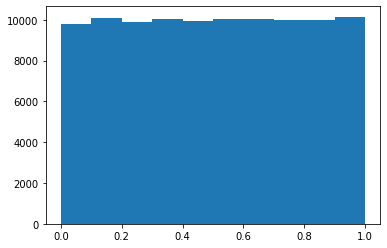

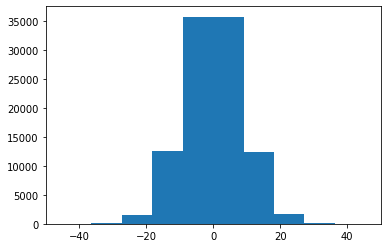

In [18]:
n = 1000
p = 100
r = 70
sigma = 1

A = np.random.standard_normal((n,r))
B = np.random.standard_normal((p,r))
E = np.random.normal(0, sigma, (n, p))

M = A @ B.T + E 

W = np.random.uniform(0,1,(n,p))

print(A.shape, B.shape, E.shape, M.shape, W.shape)
plt.hist(W.reshape(-1))
plt.show()
plt.hist(M.reshape(-1))
plt.show()

In [19]:
ks = [20, 50, 70]
lambdas = [100, 30, 5, 1, 0.1]
eps = 1e-8
max_iter = 300

LRMC (low-rank matrix completion) problem: $\text{minimize}_{X\in \mathbf{R}^{n\times p}} \|\sqrt{W} * (M-X)\|_F^2$ subject to $rank(X) ≤ k$. 

Convex relaxation of LRMC problem:$\text{minimize}_{X\in \mathbf{R}^{n\times p}} \|\sqrt{W} * (M-X)\|_F^2 + \lambda \|X\|_\star$, where $\|\cdot\|_\star$ - nuclear norm of the matrix (sum of singular values)


In [20]:
u, s, vt = np.linalg.svd(M, full_matrices=False)
u.shape, s.shape, vt.shape

((1000, 100), (100,), (100, 100))

In [21]:
def S_lambda(X, lambd):
    u, s, vt = np.linalg.svd(X, full_matrices = False)
    s = s - lambd
    s = s * (s > 0)
    return u @ np.diag(s) @ vt

def nesterov(w, k, weight, n_iter = 30):
    a, b = get_low_rank(w, k)
    prev_a, prev_b = a, b
    for i in range(n_iter):
        v_a = a + (i-1) / (i+2) * (a - prev_a)
        v_b = b + (i-1) / (i+2) * (b - prev_b)

        prev_a, prev_b = a, b
        a, b = get_low_rank(weight * w + (1 - weight) * (v_a @ v_b), k)

    return a, b

In [22]:
def S_convex_nonconvex(W, M, t, V, k = None, lambd = 0, regime = "convex"):
    # in non-convex case - low rank SVD
    # in convex case - S_lambda #look in article
    if regime == "non-convex":
        a, b = get_low_rank(t * W * M + (1 - t * W) * V, k)
        X = a @ b
    elif regime == "convex":
        X = S_lambda(t * W * M + (1 - t * W) * V, t * lambd)
    else: assert False
    return X

def WLRMA_baseline(W, M, k, max_iter, eps, t = 1, lambd = 0, regime = "non-convex"):
    # M -what we approximate
    # W - weights
    # k -rank
    # max_iter - maximum number of iterations
    # eps - 
    #t - learning rate
    # function the same as weighted_svd
    history = []
    X = M
    for i in range(max_iter):
        X = S_convex_nonconvex(W, M, t, X, k = k, lambd = lambd, regime = regime)
        history.append(weighted_frob(M - X, W))
        try:
            if np.abs((history[-1] - history[-2]) / history[-2]) < eps:
                break
        except Exception: pass
    return X, np.array(history)

def WLRMA_nesterov(W, M, k, max_iter, eps, t = 1, lambd = 0, regime = "non-convex"):
    X_1 = M # like X_{i-1}
    X_0 = M # like X_{i}
    history = []
    for i in range(1, max_iter):
        V = X_0 + (i-1) / (i+2) * (X_0 - X_1)
        X = S_convex_nonconvex(W, M, t, V, k = k, lambd = lambd, regime = regime)
        history.append(weighted_frob(M - X, W))
        try:
            if np.abs((history[-1] - history[-2]) / history[-2]) < eps:
                break
        except Exception: pass
        X_1 = X_0
        X_0 = X
    return X, np.array(history)

def WLRMA_anderson(W, M, k, max_iter, eps, t = 1, lambd = 0, regime = "non-convex", m = 10, gamma = 0.0):
    Y = M
    sh = Y.shape
    y = Y.reshape(-1,1)
    X = S_convex_nonconvex(W, M, t, Y, k = k, lambd = lambd, regime = regime)
    R = []
    F = []
    history = []
    for i in range(max_iter):
        f = (W * M + (1 - W) * X).reshape(-1,1)
        r = f - y
        R.append(r)
        F.append(f)

        tmp = np.stack(R).reshape(len(R), -1).T
        tmp = np.linalg.inv(tmp.T @ tmp + gamma * np.eye(len(R))) 
        one = np.ones((len(R), 1))
        alpha =  tmp @ one / (one.T @ tmp @ one)
        y = np.stack(F).reshape(len(F), -1).T @ alpha
        Y = y.reshape(sh)
        X = S_convex_nonconvex(W, M, t, Y, k = k, lambd = lambd, regime = regime)
        if len(R) >= m:
            R = R[1:]
            F = F[1:]
        history.append(weighted_frob(M - X, W))
        try:
            if np.abs((history[-1] - history[-2]) / history[-2]) < eps:
                break
        except Exception: pass
    return X, np.array(history)  

### non-convex

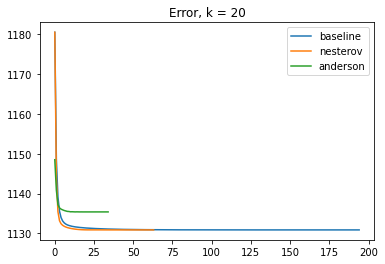

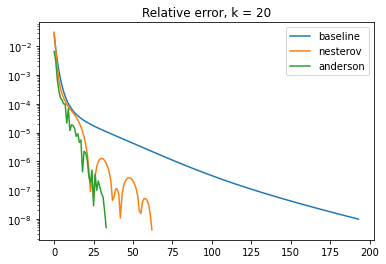

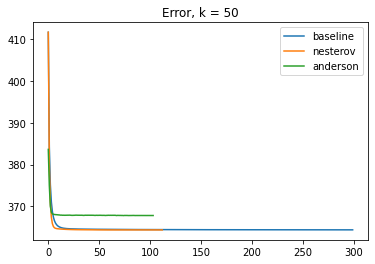

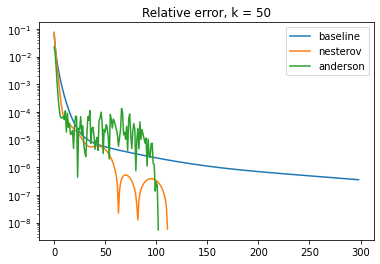

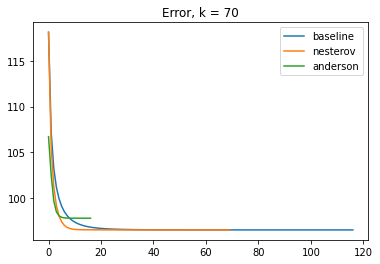

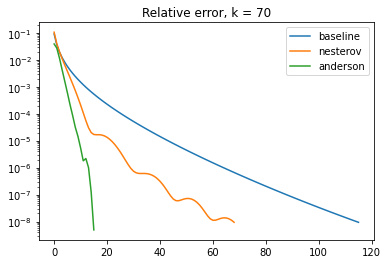

In [23]:
for k in ks:
    X_baseline, his_baseline = WLRMA_baseline(W, M, k, max_iter, eps, t = 1, lambd = 0, regime = "non-convex")
    X_nesterov, his_nesterov = WLRMA_nesterov(W, M, k, max_iter, eps, t = 1, lambd = 0, regime = "non-convex")
    X_anderson, his_anderson = WLRMA_anderson(W, M, k, max_iter, eps, t = 1, lambd = 0, regime = "non-convex")
    
    plt.plot(his_baseline, label = "baseline")
    plt.plot(his_nesterov, label = "nesterov")
    plt.plot(his_anderson, label = "anderson")
    plt.title("Error, k = {}".format(k))
    plt.legend()
    plt.show()

    plt.semilogy(np.abs((his_baseline[1:] - his_baseline[:-1]) / his_baseline[:-1]), label = "baseline")
    plt.semilogy(np.abs((his_nesterov[1:] - his_nesterov[:-1]) / his_nesterov[:-1]), label = "nesterov")
    plt.semilogy(np.abs((his_anderson[1:] - his_anderson[:-1]) / his_anderson[:-1]), label = "anderson")
    plt.title("Relative error, k = {}".format(k))
    plt.legend()
    plt.show()

### convex

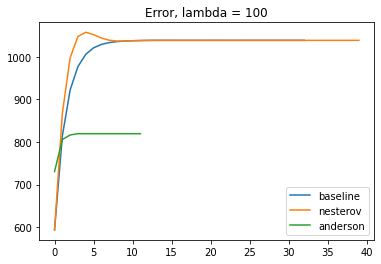

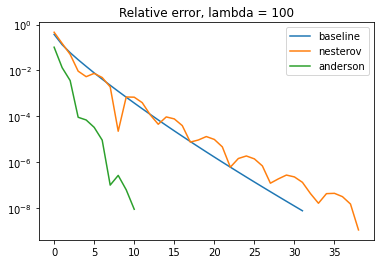

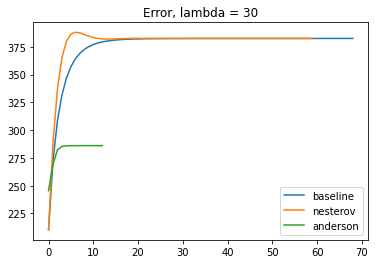

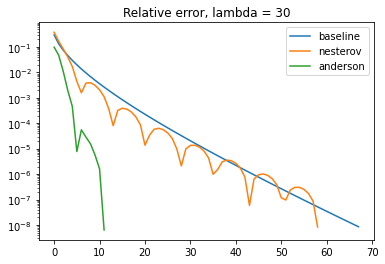

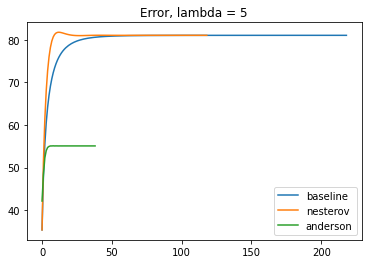

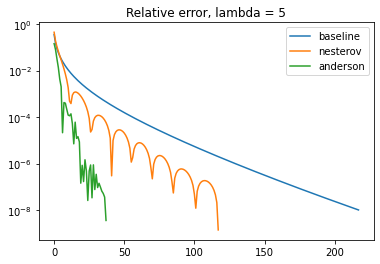

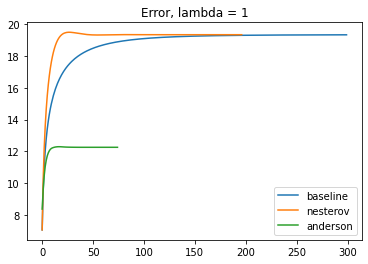

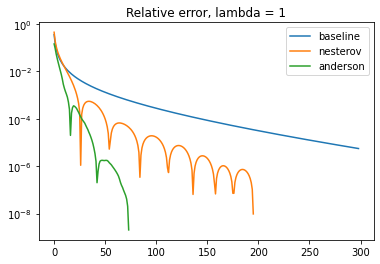

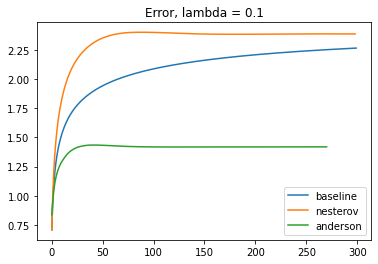

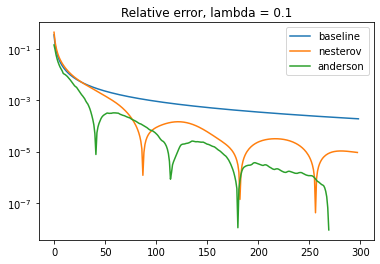

In [24]:
for lambd in lambdas:
    X_baseline, his_baseline = WLRMA_baseline(W, M, k, max_iter, eps, t = 1, lambd = lambd, regime = "convex")
    X_nesterov, his_nesterov = WLRMA_nesterov(W, M, k, max_iter, eps, t = 1, lambd = lambd, regime = "convex")
    X_anderson, his_anderson = WLRMA_anderson(W, M, k, max_iter, eps, t = 1, lambd = lambd, regime = "convex")
    
    plt.plot(his_baseline, label = "baseline")
    plt.plot(his_nesterov, label = "nesterov")
    plt.plot(his_anderson, label = "anderson")
    plt.title("Error, lambda = {}".format(lambd))
    plt.legend()
    plt.show()

    plt.semilogy(np.abs((his_baseline[1:] - his_baseline[:-1]) / his_baseline[:-1]), label = "baseline")
    plt.semilogy(np.abs((his_nesterov[1:] - his_nesterov[:-1]) / his_nesterov[:-1]), label = "nesterov")
    plt.semilogy(np.abs((his_anderson[1:] - his_anderson[:-1]) / his_anderson[:-1]), label = "anderson")
    plt.title("Relative error, lambda = {}".format(lambd))
    plt.legend()
    plt.show()

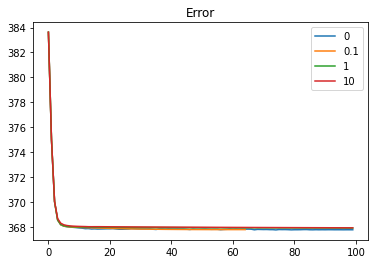

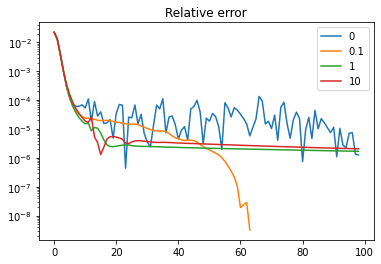

In [25]:
for gamma in [0, 0.1, 1, 10]:
    X_anderson, his_anderson = WLRMA_anderson(W, M, k = 50, max_iter = 100, eps = eps, 
                                              t = 1, lambd = lambd, regime = "non-convex", gamma = gamma)
    plt.plot(his_anderson, label = gamma)
    plt.title("Error")
    plt.legend()
plt.show()

for gamma in [0, 0.1, 1, 10]:
    X_anderson, his_anderson = WLRMA_anderson(W, M, k = 50, max_iter = 100, eps  = eps,
                                              t = 1, lambd = lambd, regime = "non-convex", gamma = gamma)
    plt.semilogy(np.abs((his_anderson[1:] - his_anderson[:-1]) / his_anderson[:-1]), label = gamma)
    plt.title("Relative error")
    plt.legend()
plt.show()